In [7]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (20, 8)})

In [8]:
from models_gaussian_2d import *
from eval_utils import *
import time

In [9]:
from sklearn.decomposition import PCA
from celluloid import Camera
import matplotlib.cd ..cm as cm
from IPython.display import display, Markdown, Latex, HTML

In [10]:
import os
# os.chdir('./wodociagi')

In [11]:
import pandas as pd
import numpy as np

# from tune_params import prepare_data

In [12]:
plt.rcParams.update({'figure.figsize': (20, 8)})

# Prepare Data

In [14]:
df_main = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
df_main = df_main.ffill()
df_main["V_delta"] = np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist())

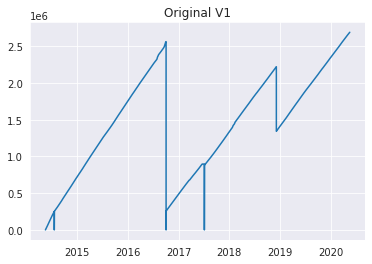

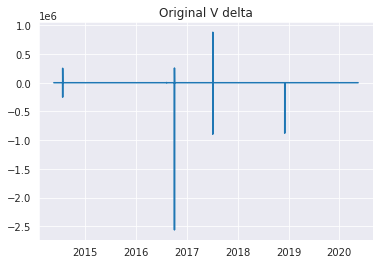

In [15]:
plt.plot(df_main["mtime"], df_main["V1"])
plt.title("Original V1")
plt.show()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("Original V delta")
plt.show()

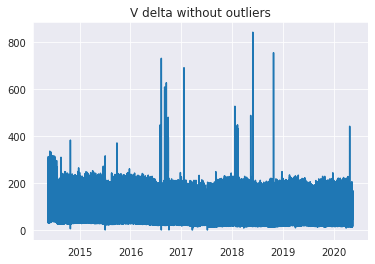

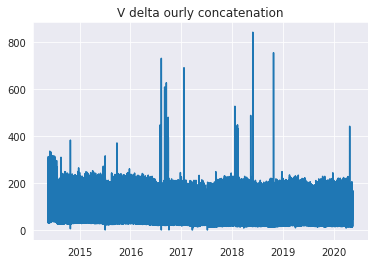

In [52]:
df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta without outliers")
plt.show()

df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta ourly concatenation")
plt.show()

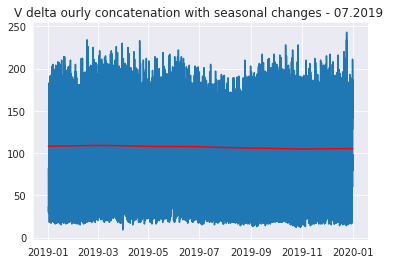

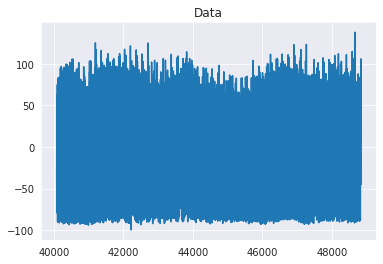

In [53]:
plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], df_main.loc[(df_main.mtime.dt.year == 2019), "V_delta"])


seasonal_changes = df_main.V_delta.rolling(24 * 42 * 6, center=True, min_periods=2).mean().rolling(24 * 7 * 6, center=True, min_periods=2).mean()[(df_main.mtime.dt.year == 2019)]

plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], seasonal_changes , color = "red")
plt.title("V delta ourly concatenation with seasonal changes - 07.2019 ")
plt.show()

data = df_main.V_delta[(df_main.mtime.dt.year == 2019)] - seasonal_changes

plt.plot(data)
plt.title("Data")

lengths = np.array([24 * 7 * 6 for _ in range(data.shape[0] // (24 * 7 * 6))] + [
    data.shape[0] - (data.shape[0] // (24 * 6 * 7)) * 24 * 7 * 6])
Y_true = data.values.reshape(-1, 1)

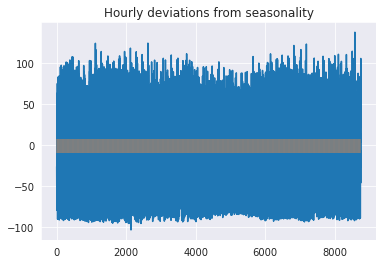

In [18]:
plt.plot(Y_true)
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -10, 7.5, color='grey')
plt.show()

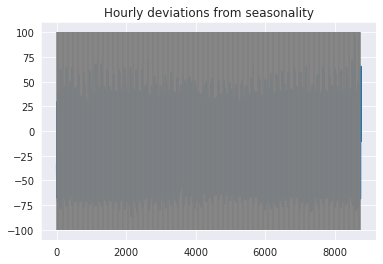

In [19]:
plt.plot(pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean())
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -100, 100, color='grey')
plt.show()

In [20]:
print(Y_true.shape)
Y_true = pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean().values.reshape(-1, 1)
print(Y_true.shape)

(8760, 1)
(8760, 1)


# Build model

In [21]:
n = 4
l = 3
lr = 0.03271365590433669
ITER = 714450


lr = 0.1
ITER = 70000

TOLERANCE = 1e-4

def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"first-runs-2",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": None,
        "lr": lr,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

In [22]:
hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                log_config={'metrics_after_convergence': True})
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)

wandb: Currently logged in as: kabalce (cirglaboratory). Use `wandb login --relogin` to force relogin


In [23]:
start = time.perf_counter()
densehmm.fit_coocs(Y_true,lengths)
time_tmp = time.perf_counter() - start

2022-09-21 12:28:03.579279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-21 12:28:03.579344: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 12:28:03.579393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-09-21 12:28:03.588788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 12:28:03.641652: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization p

In [24]:
# densehmm_org_aparms = densehmm
# densehmm_100k = densehmm
# densehmm_200k = densehmm
# densehmm_700k = densehmm
# densehmm_500k = densehmm

# Results

## Embeddings movement

In [25]:
z_init = np.transpose(hmm_monitor.z[-1])
pca_z = PCA(n_components=2).fit(z_init)
z = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]

z0 = list(hmm_monitor.z0)

u_init = hmm_monitor.u[-1]
pca_u = PCA(n_components=2).fit(u_init)
u = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]

In [26]:
# Draw embeddings trajectories

def draw_embeddings(embeding_list, name="?"):
    fig = plt.figure(figsize=(5, 5))
    camera = Camera(fig)
    cmap = cm.rainbow(np.linspace(0, 1, len(embeding_list[0])))
    for z_el in embeding_list:
        if z_el.shape[1] > 1:
            plt.scatter(z_el[:, 0], z_el[:, 1], color=cmap)
        else:
            plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
        camera.snap()
    plt.title(f"Embaddings trajectory:  {name}")
    animation = camera.animate().to_html5_video()
    wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation)})
    display(HTML(animation))
    plt.close()

In [27]:
draw_embeddings(z, "z")
draw_embeddings(z0, "z0")
draw_embeddings(u, "u")

## Embedding similarities

In [28]:
# Draw graph scaled with width and alpha
representation = densehmm.get_representations()

In [29]:
u_fin, z_fin, z0_fin = representation

In [30]:
u_fin

array([[ 2.36139199,  0.36868136, -1.67820466],
       [ 0.89917176,  1.63781038, -0.27222497],
       [-0.5635224 , -1.38685165,  1.09556322],
       [-2.64065699,  1.14093269,  0.93954493]])

In [31]:
z_fin

array([[ 1.09819684,  1.01701993,  1.06811443, -1.28824942],
       [-0.61041964,  1.06891706, -1.7324712 ,  1.25476727],
       [ 0.18365769,  0.51497717,  0.49824012,  0.33186677]])

In [32]:
z0_fin

array([[-0.45502651],
       [-1.5555938 ],
       [ 0.73480893]])

In [33]:
np.matmul(u_fin, z_fin)

array([[ 2.06000769,  1.93143542,  1.04735815, -3.13639292],
       [-0.06228025,  2.52496941, -2.01267437,  0.80637094],
       [ 0.42891158, -1.49135286,  2.34662769, -0.65063764],
       [-3.42385424, -0.98219417, -4.3290379 ,  5.14523359]])

In [34]:
z0_fin_red = z0[-1]
z_fin_red = z[-1]
u_fin_red = u[-1]

In [35]:
A_trained = np.exp(np.matmul(u_fin, z_fin)) / np.exp(np.matmul(u_fin, z_fin)).sum(axis=1).reshape(-1, 1)

In [36]:
A_largest = A_trained * (A_trained == A_trained.max(axis=1).reshape(-1, 1))

In [37]:
A_largest

array([[0.44481182, 0.        , 0.        , 0.        ],
       [0.        , 0.7903623 , 0.        , 0.        ],
       [0.        , 0.        , 0.82074675, 0.        ],
       [0.        , 0.        , 0.        , 0.99755711]])

In [38]:
import itertools

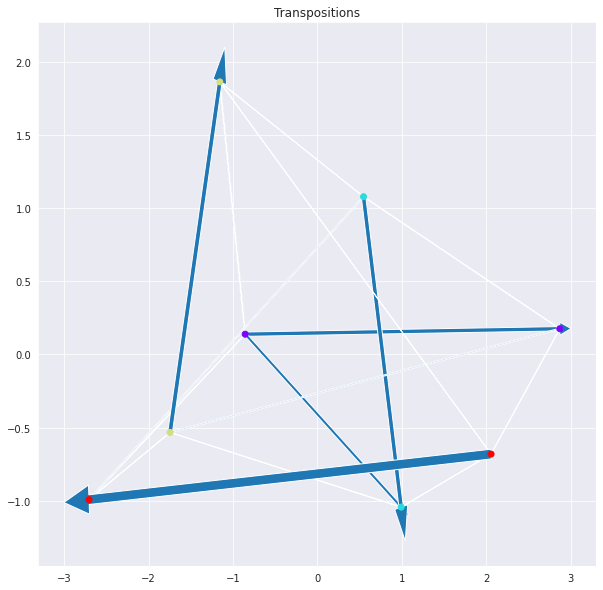

In [39]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    plt.arrow(z_fin_red[i, 0], z_fin_red[i, 1], u_fin_red[j, 0] - z_fin_red[i, 0], u_fin_red[j, 1] - z_fin_red[i, 1], width=A_trained[i, j]/15)

plt.scatter(z_fin_red[:, 0], z_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(u_fin_red[:, 0], u_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

In [40]:
z_fin_red

array([[-0.85592225,  0.13771284],
       [ 0.54560908,  1.07658581],
       [-1.74604528, -0.53321791],
       [ 2.05635845, -0.68108074]])

In [41]:
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [42]:
pca_uz = PCA(n_components=2)
uz_fin_red = pca_uz.fit_transform(uz_fin)

In [43]:
uz_fin_red

array([[-2.92655577, -0.46176454],
       [-0.65191932, -1.64724263],
       [ 0.06102147,  2.84790311],
       [ 3.51745362, -0.73889594]])

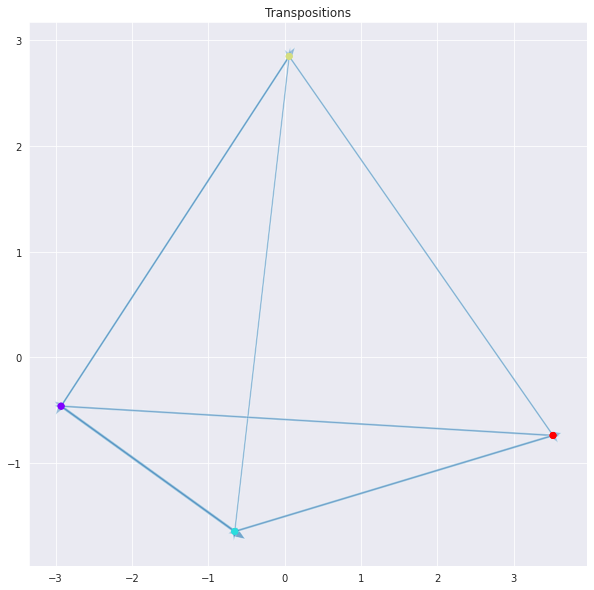

In [44]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    if i == j:
        continue
    plt.arrow(uz_fin_red[i, 0], uz_fin_red[i, 1], uz_fin_red[j, 0] - uz_fin_red[i, 0], uz_fin_red[j, 1] - uz_fin_red[i, 1], width=(A_trained[i, j] / 1.5 + 0.33) * 0.06, alpha=A_trained[i, j] / 1.5 + 0.33)  #, color=cm.rainbow(A_trained[i, j] )

plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

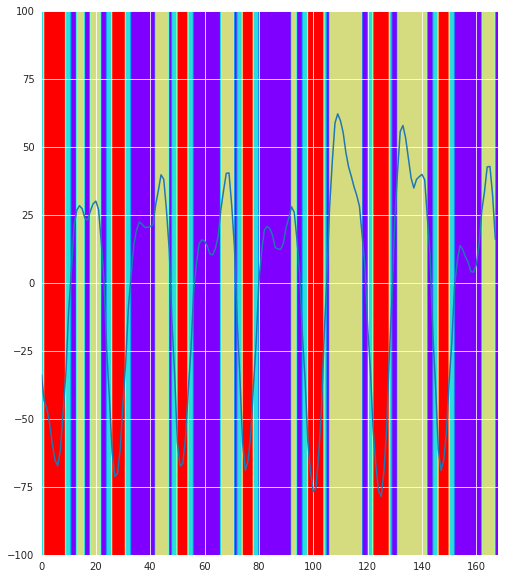

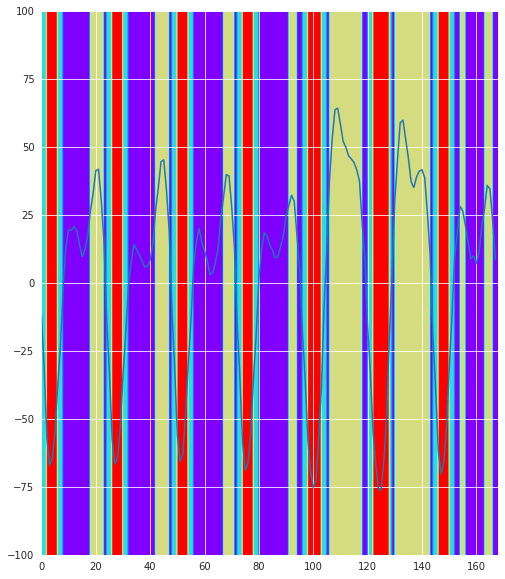

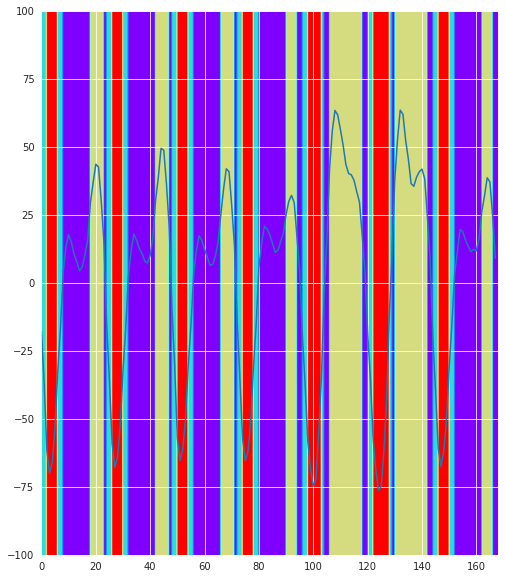

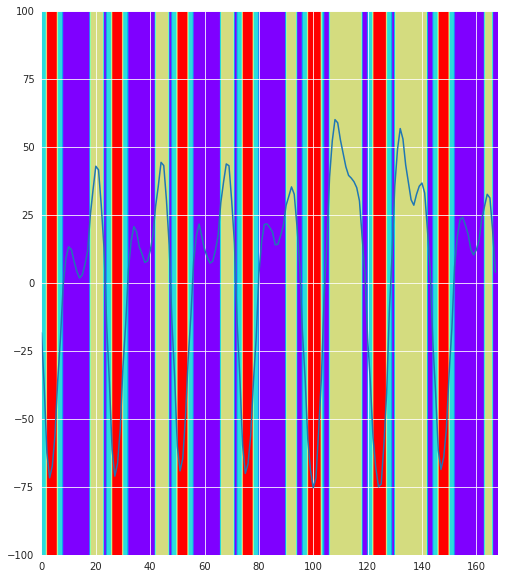

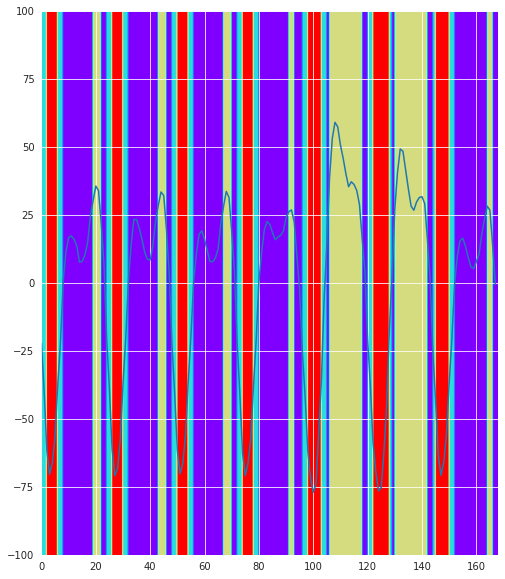

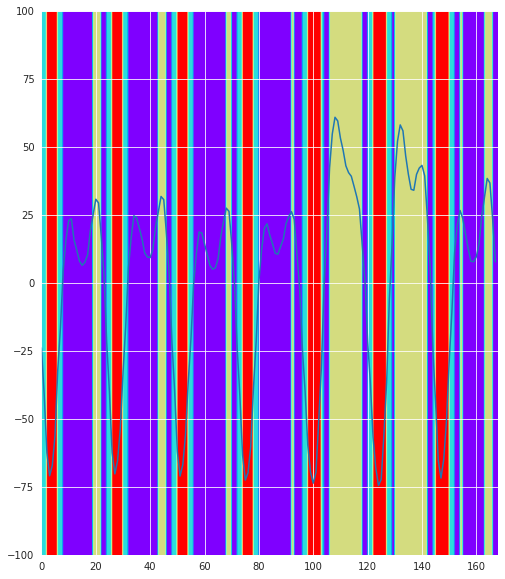

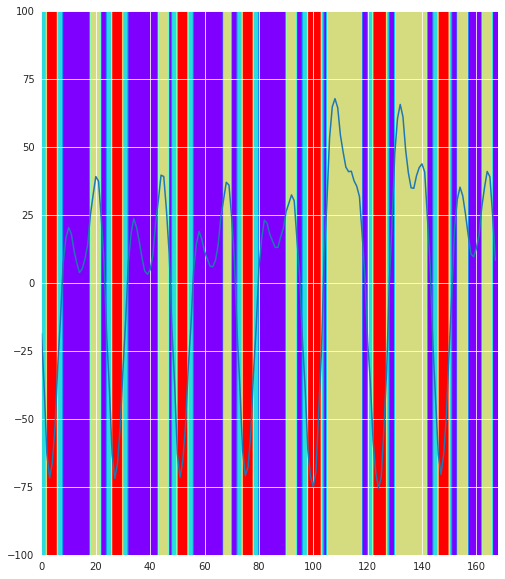

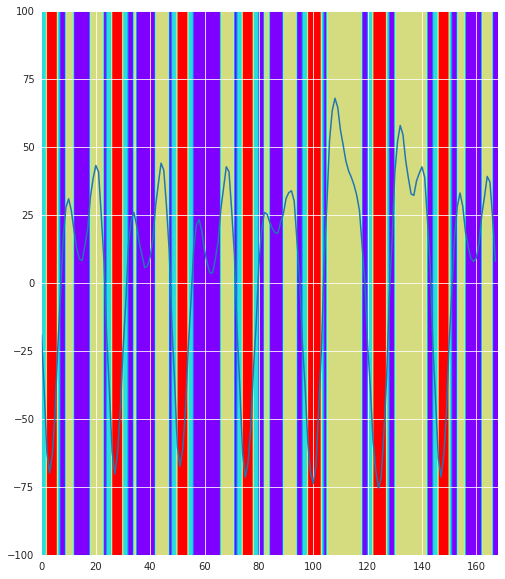

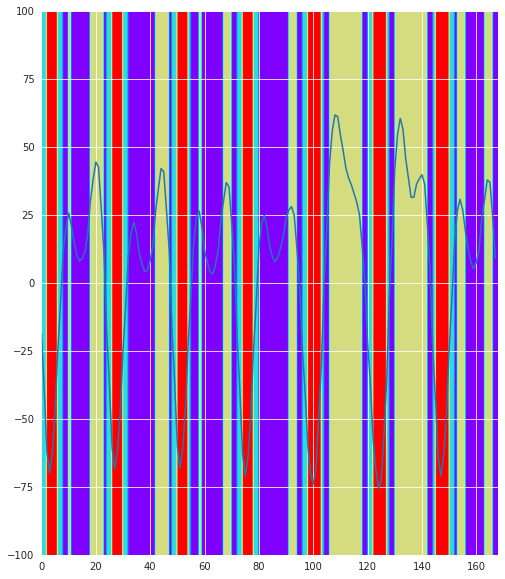

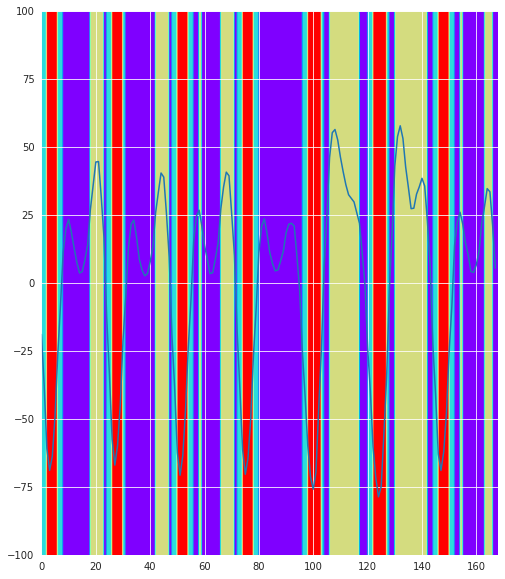

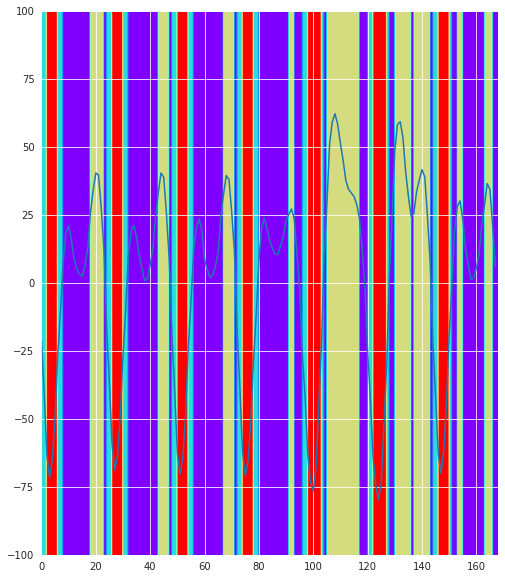

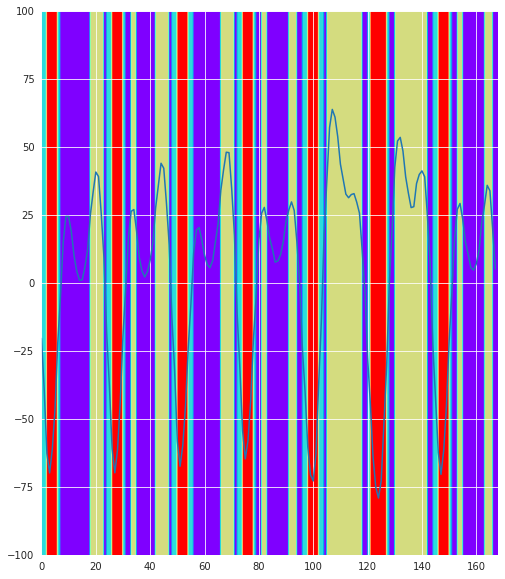

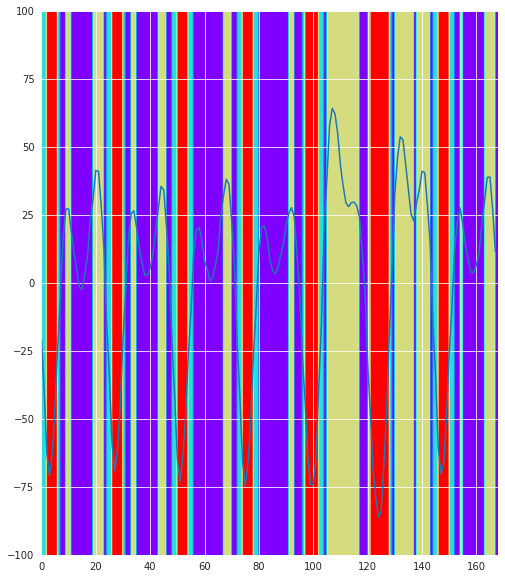

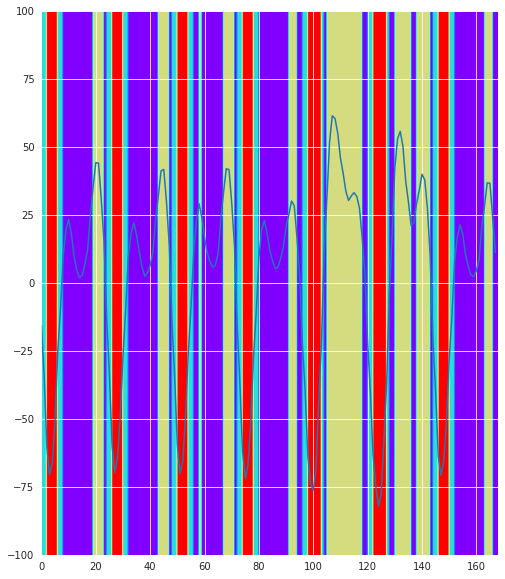

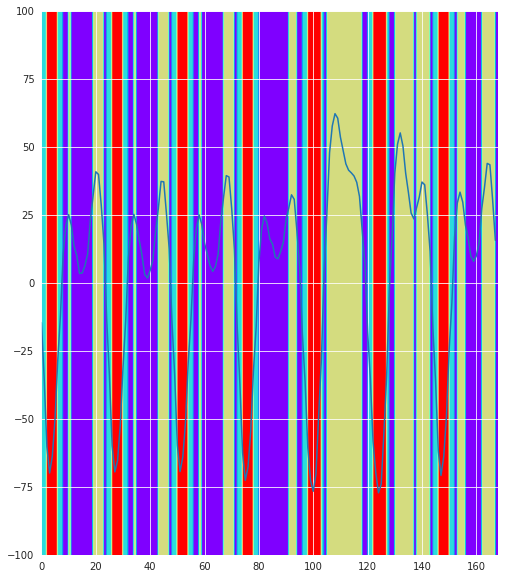

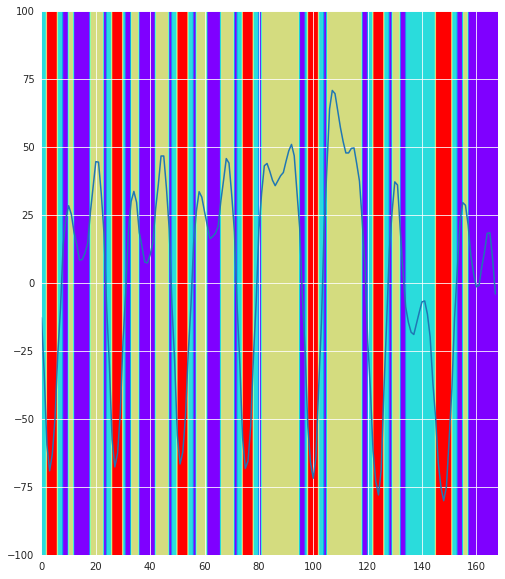

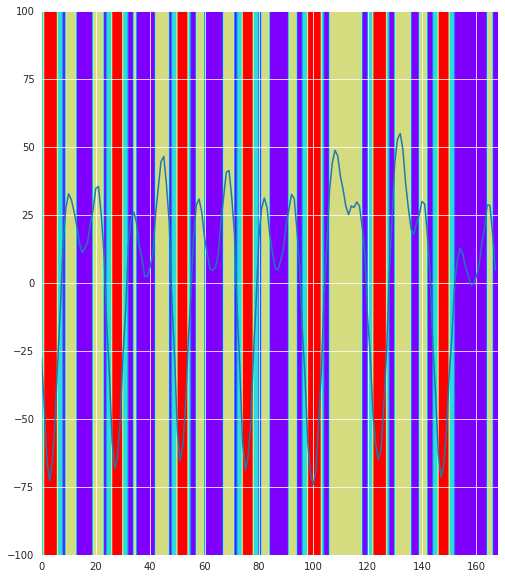

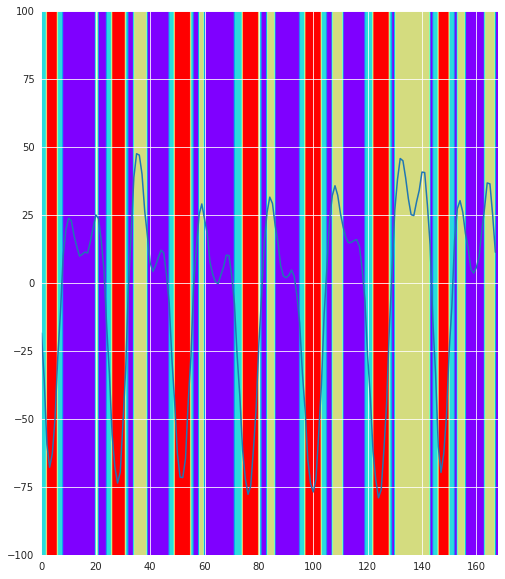

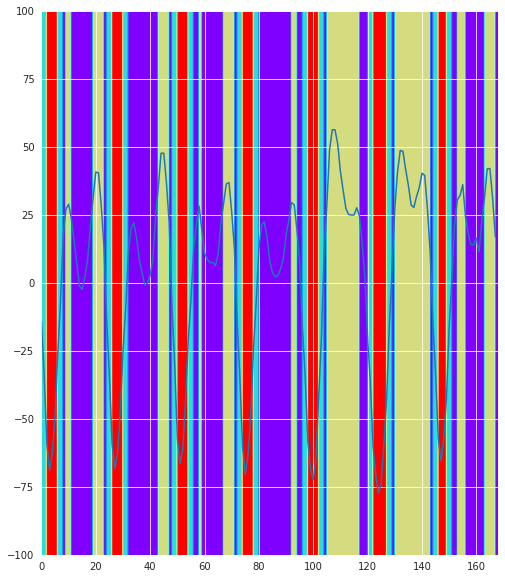

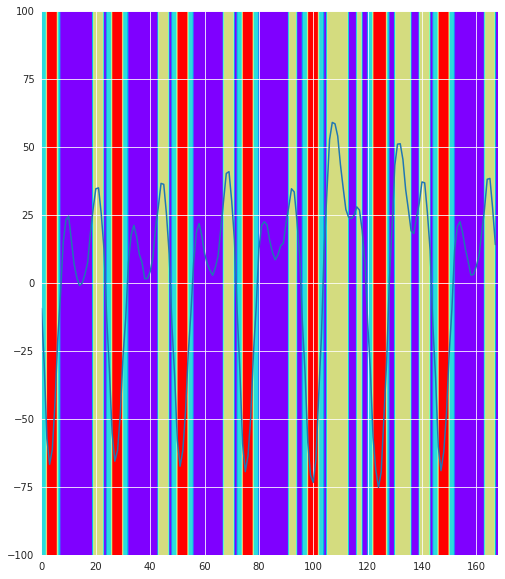

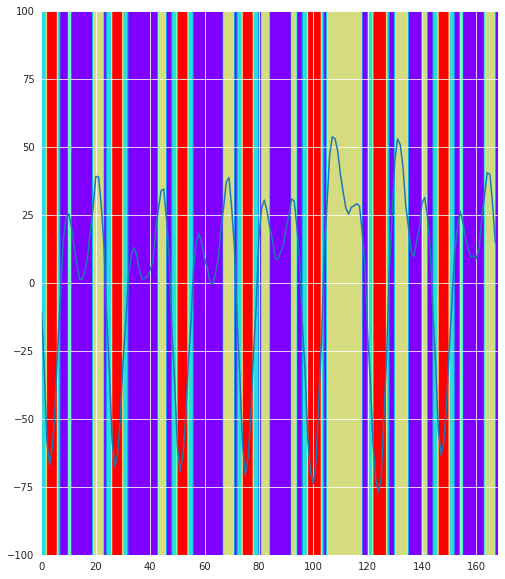

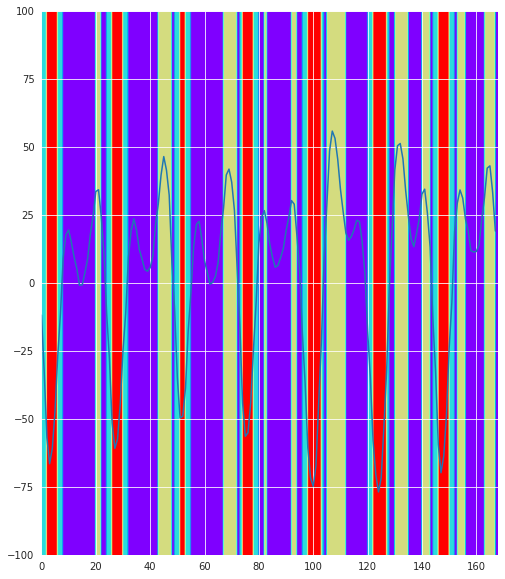

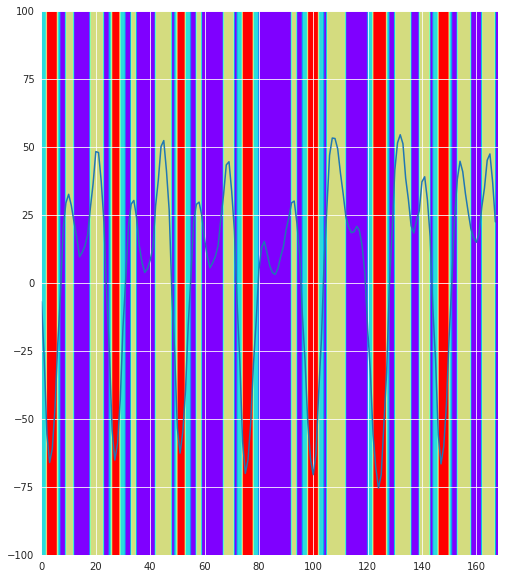

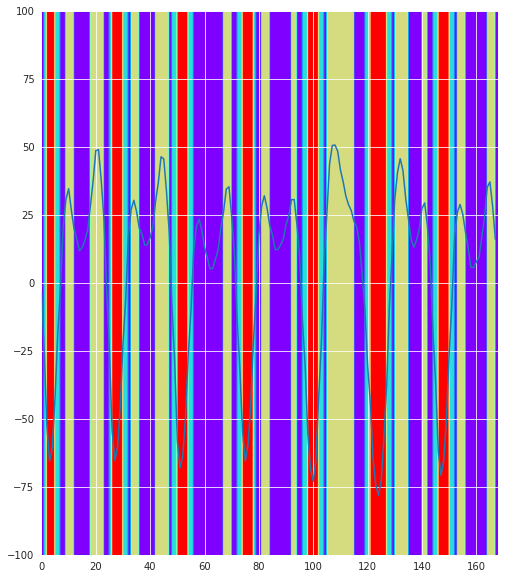

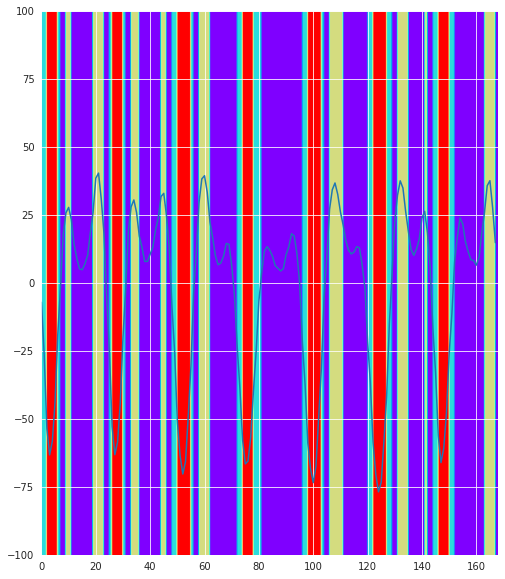

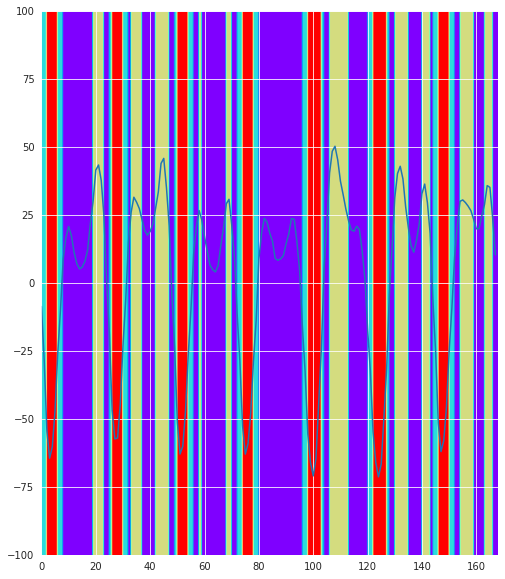

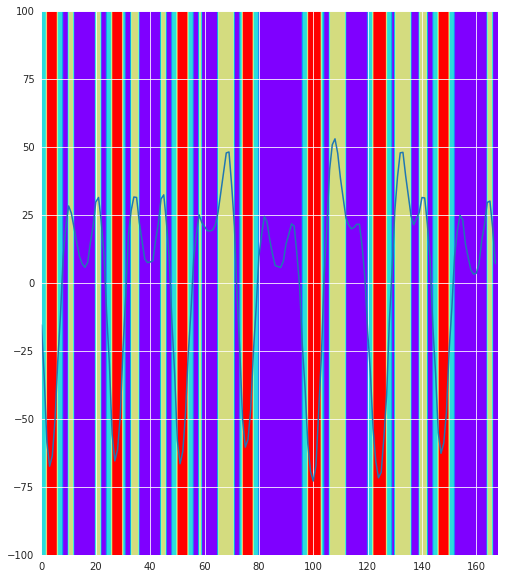

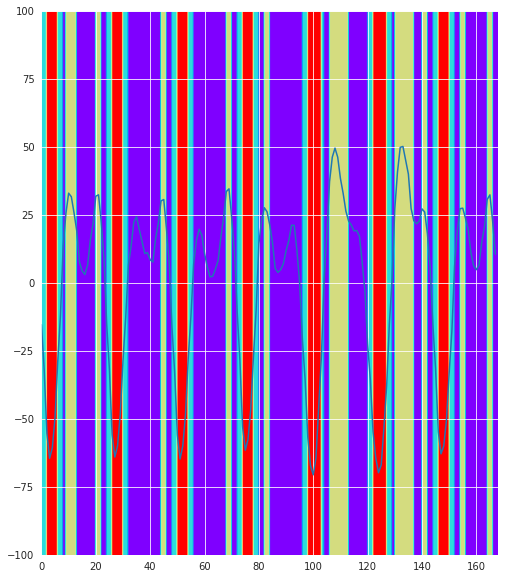

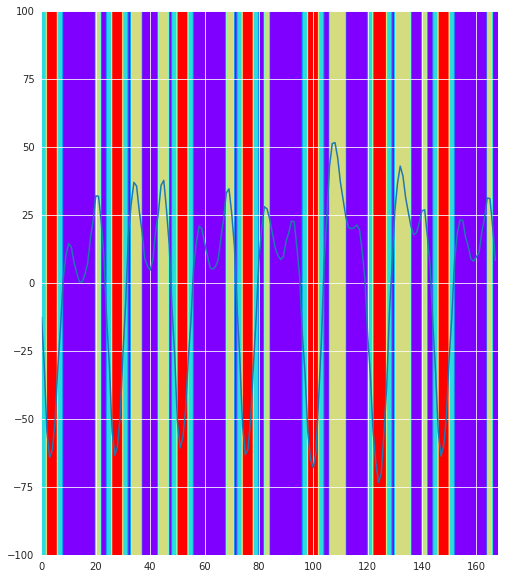

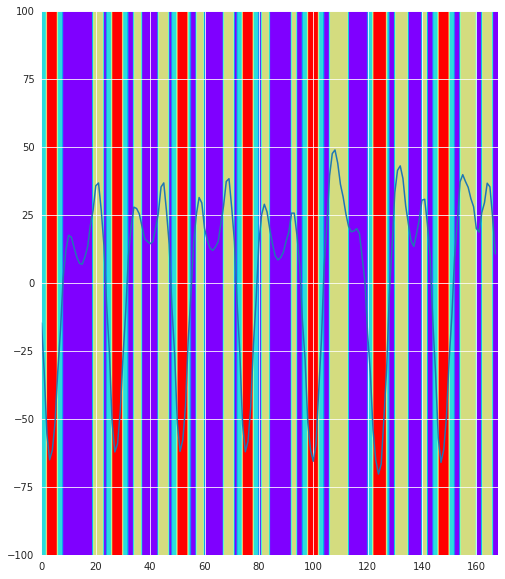

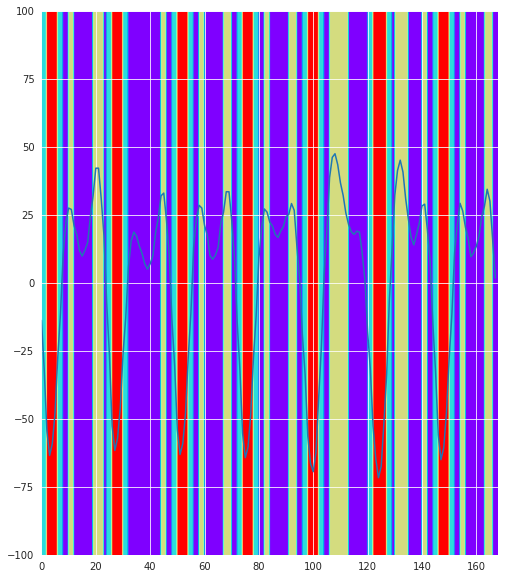

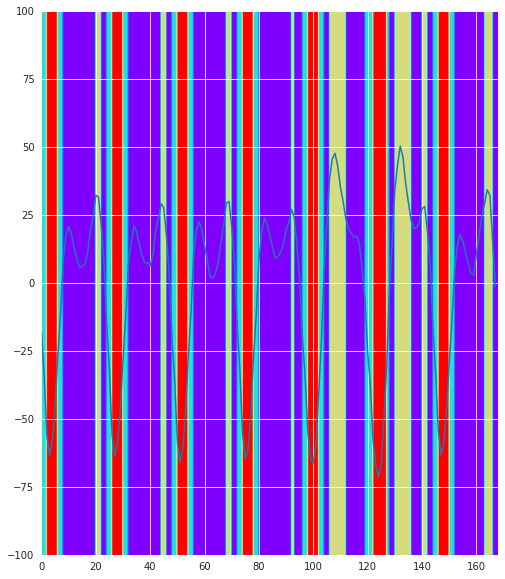

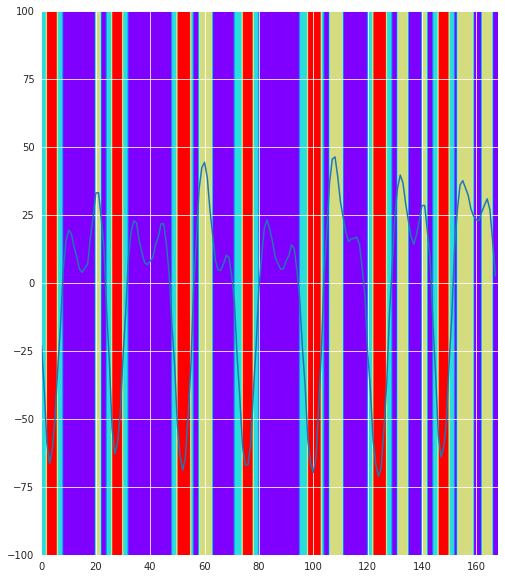

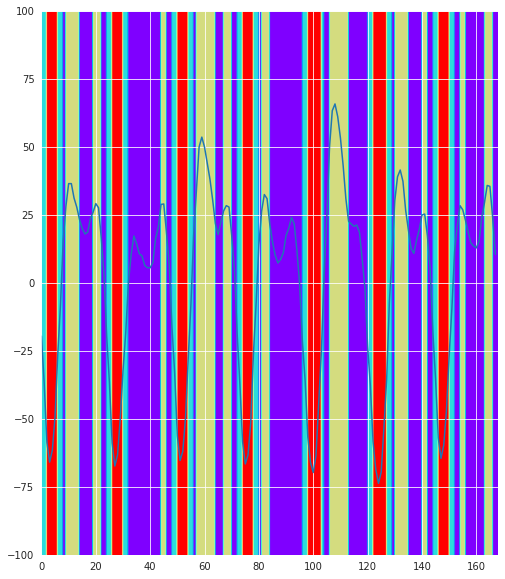

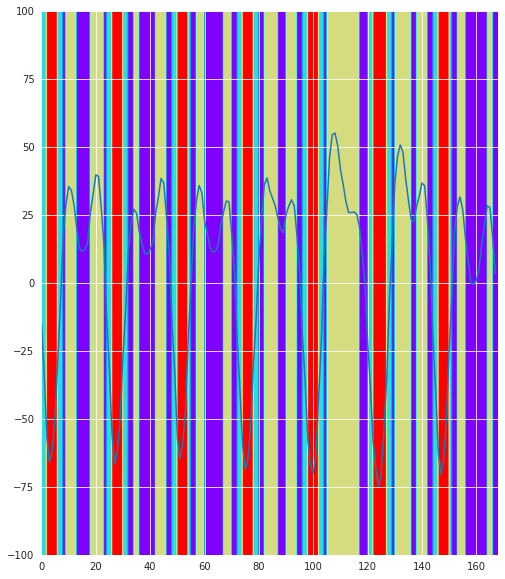

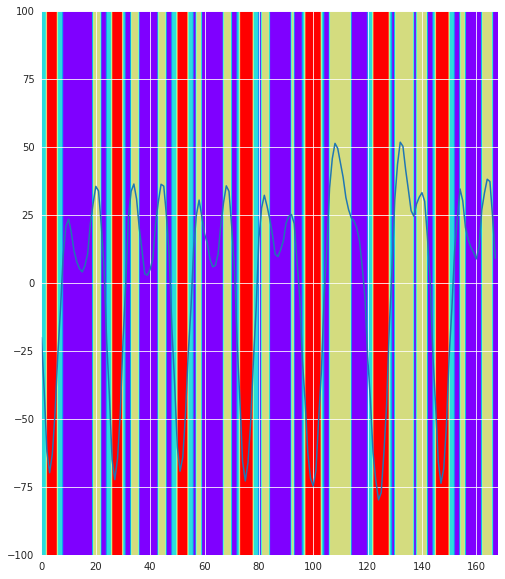

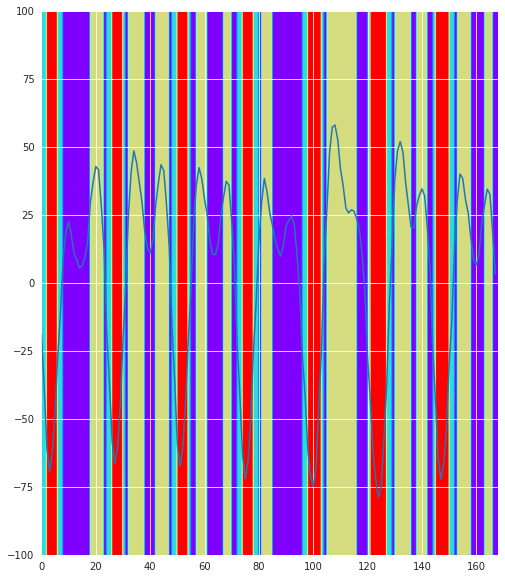

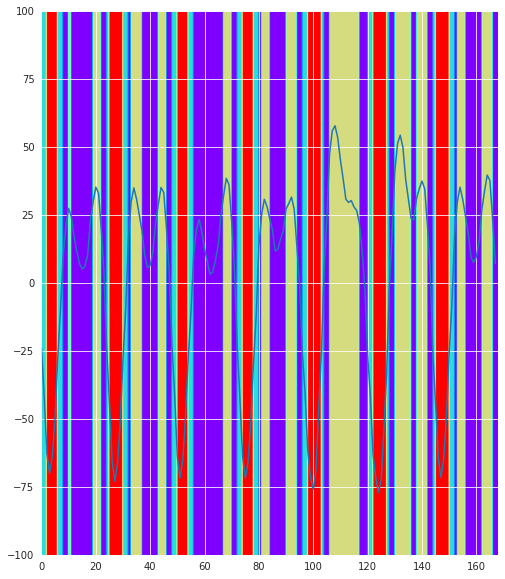

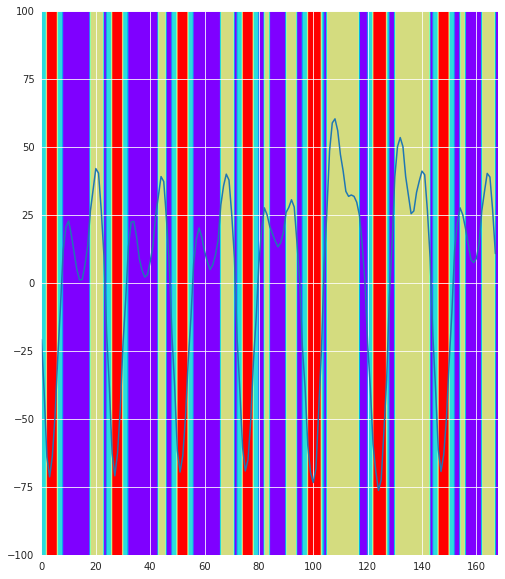

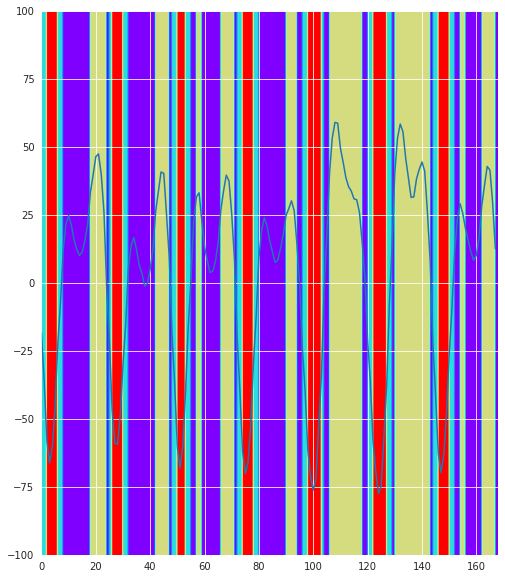

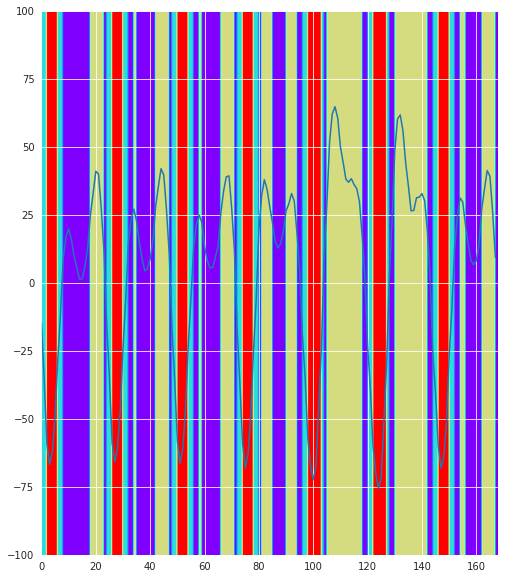

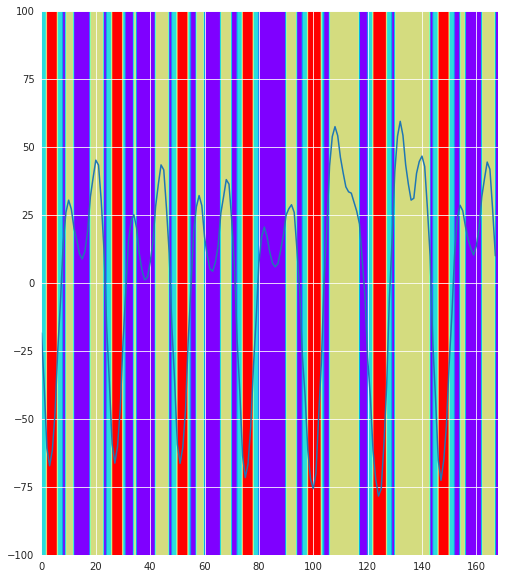

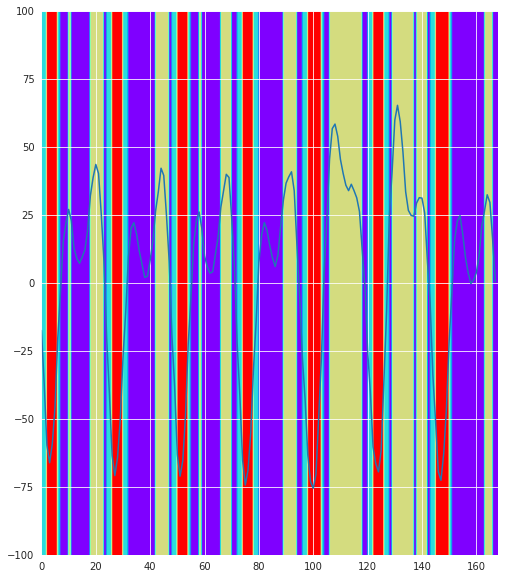

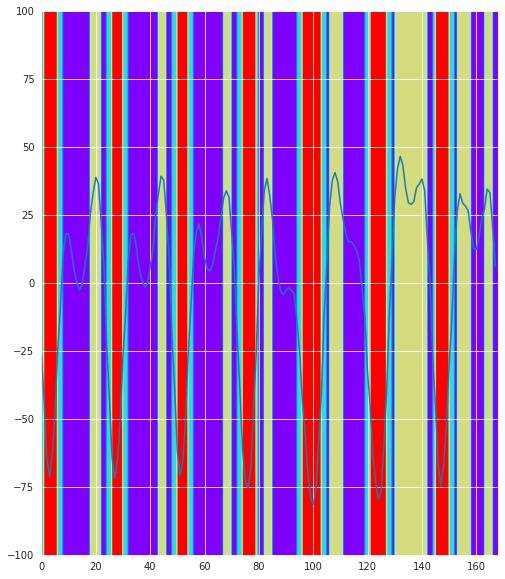

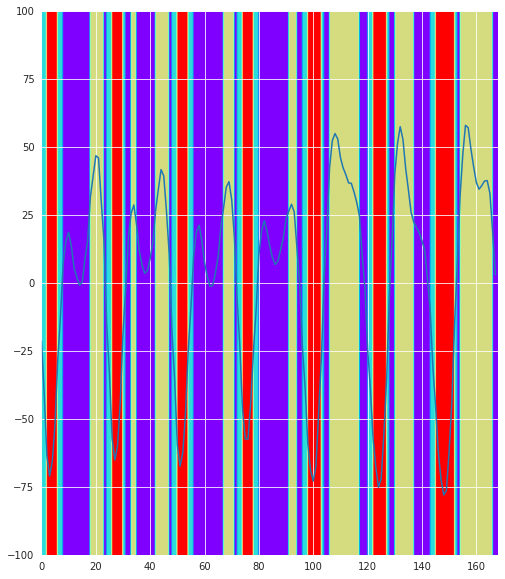

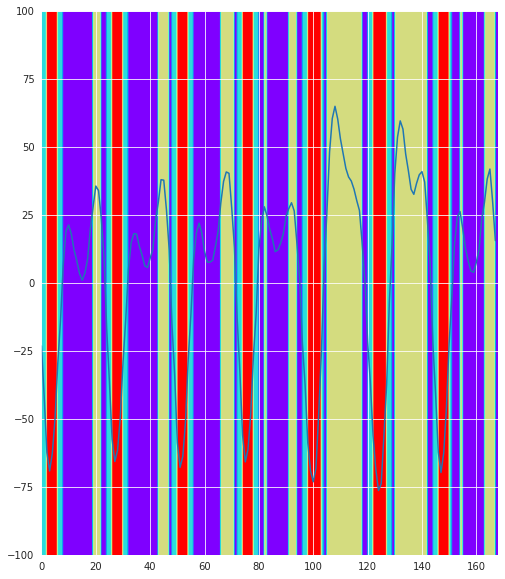

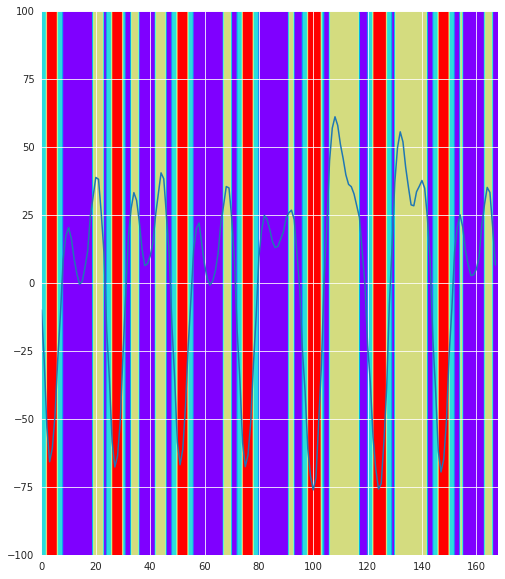

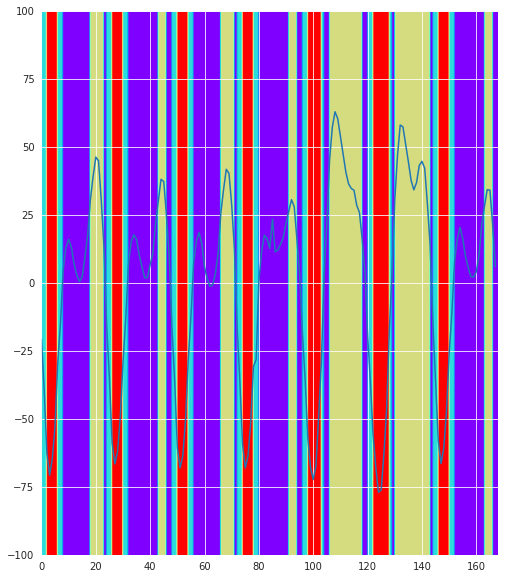

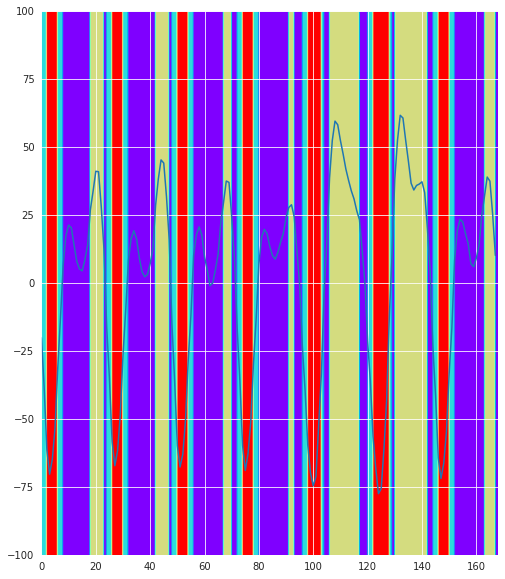

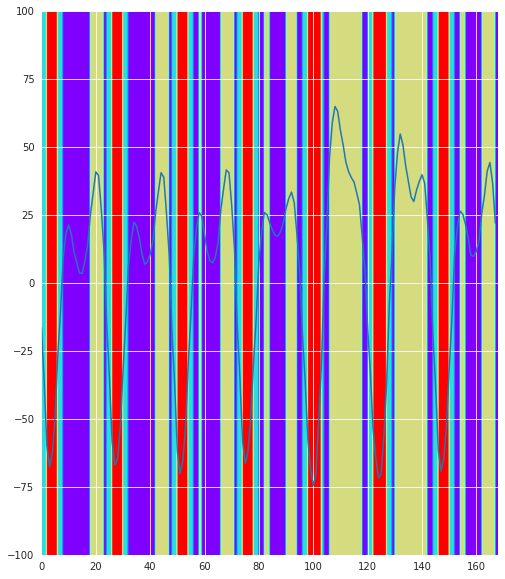

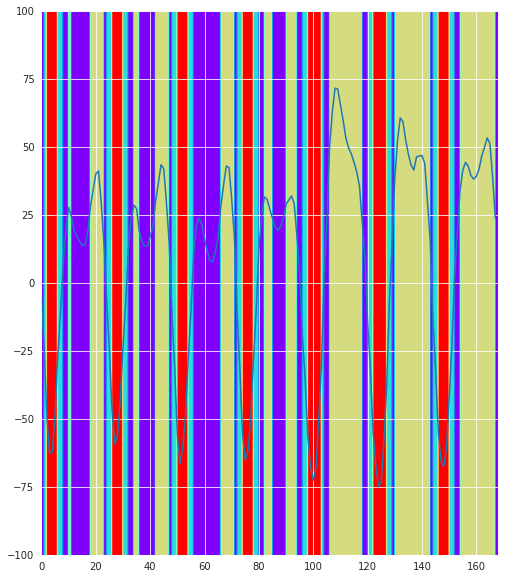

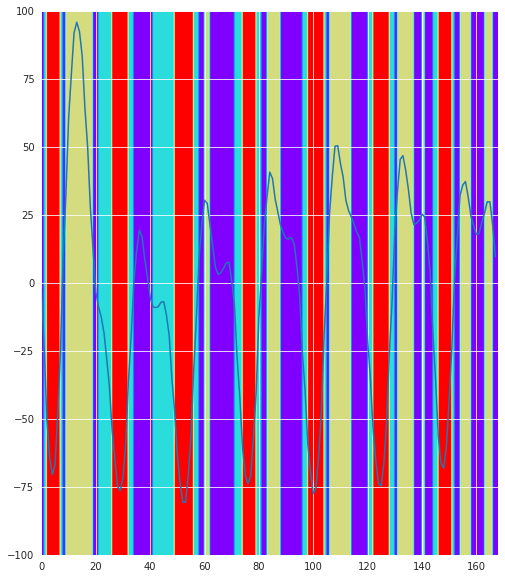

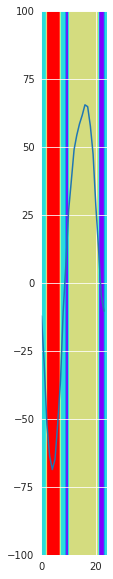

In [45]:
states = densehmm.predict(Y_true).reshape(1, -1)

interval = 7 * 24

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(10, 10))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -100, 100), cmap=cm.rainbow)
    plt.show()

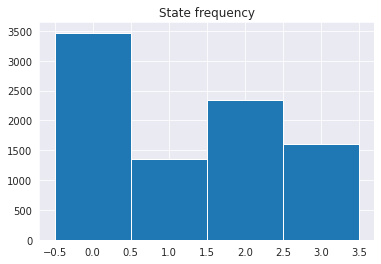

In [46]:
plt.hist(densehmm.predict(Y_true).reshape(-1), [i - 0.5 for i in range(n+1)])
plt.title("State frequency")
plt.show()

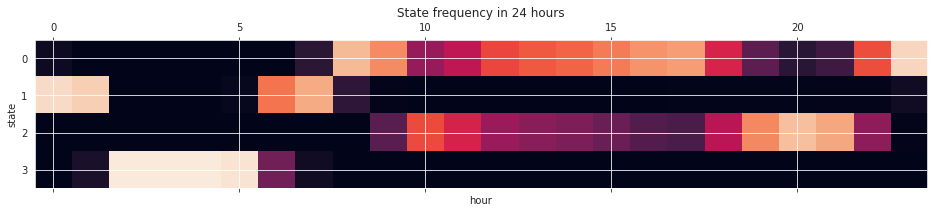

In [47]:
plt.matshow(pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % 24 }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

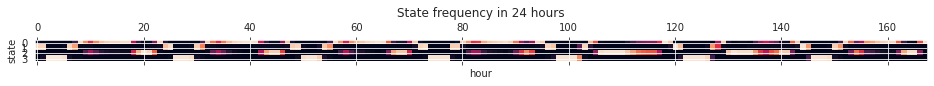

In [48]:
plt.matshow(pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 7) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

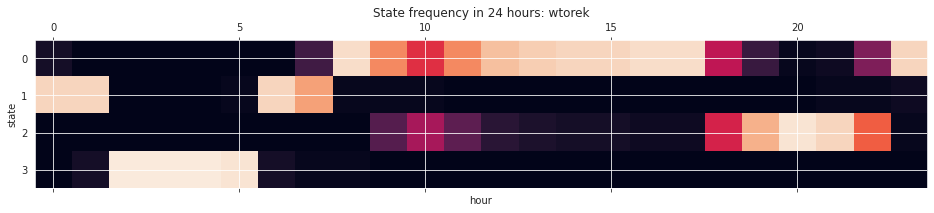

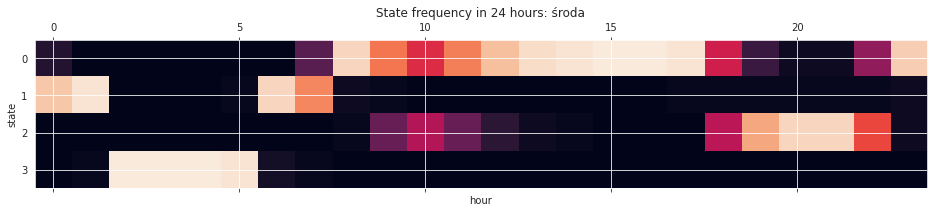

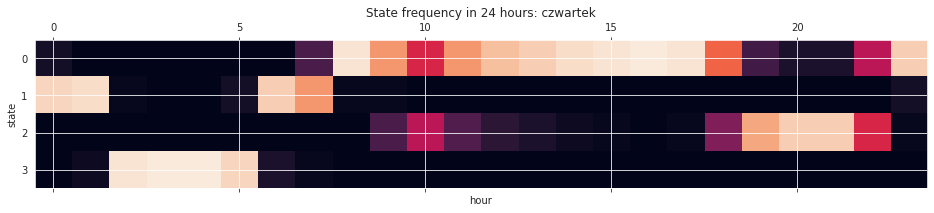

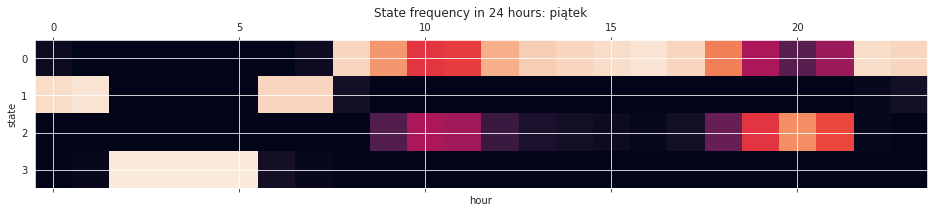

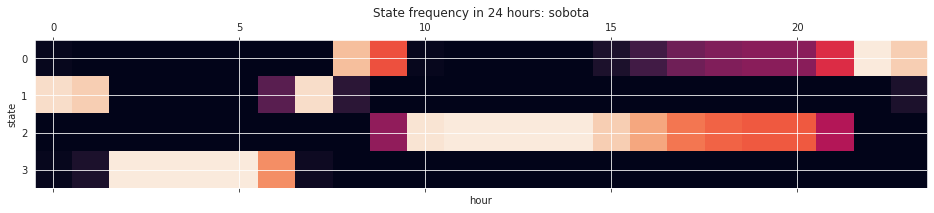

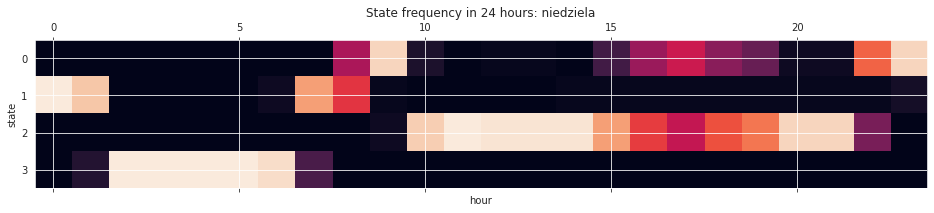

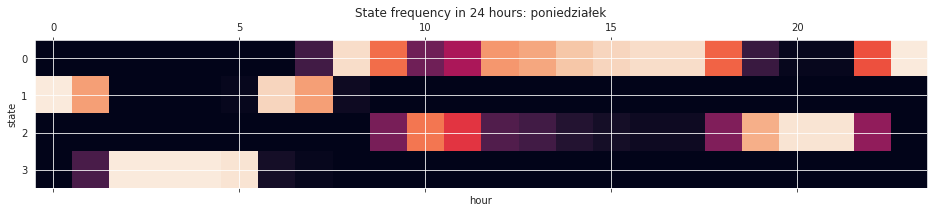

In [51]:
weekly = pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 7) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
l = weekly.shape[1] // 7
days = ['wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela', 'poniedziałek']
for i in range(7):
    plt.matshow(weekly[:, (l*i) : (l*(i+1))])
    plt.ylabel("state")
    plt.xlabel("hour")
    plt.title(f"State frequency in 24 hours: {days[i]}")
    plt.show()